# DeepSurv in Social Science: Modelling Refugee Journey Duration

* This notebook applies DeepSurv, a Cox proportional hazards deep neural network, in a social science setting. I study whether DeepSurv outperforms the predictive accuracy of traditional Cox models. The basis for comparison is Harrel's c-index, which measures how well each model ranks the arrival times of refugees. The c-index of the best traditional Cox model is equal to 0.72. 
* The script first loads required packages. Those include DeepSurv, the deep learning package "Lasagne" as well as the widely-used Python packages numpy, pandas and matplotlib.

In [1]:
import sys
sys.path.append('../deepsurv')
import deep_surv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/Users/timfingerhut/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


* These following three lines of code specify the training dataset. The second line of code reads the csv file. The third line outputs the first lines of code in order to make sure that the data was loaded correctly.

In [2]:
train_dataset_fp = './2006_final.csv'
train_df = pd.read_csv(train_dataset_fp)
train_df.head()

,fail_1,dur,country1,country2,country4,country5,country6,country7,country8,country9,...,mmx_age_imp,english,french,mmx_yearsinschool_imp,uni_apprentice_abroad,practical_uni,theoretical_uni,phd,religion_islam,religion_christianity
0,1,30,1,0,0,0,0,0,0,0,...,0.276923,0,0,0.526316,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0.292308,1,0,0.578947,1,0,1,0,1,0
2,1,60,1,0,0,0,0,0,0,0,...,0.292308,0,0,0.526316,0,0,0,0,1,0
3,1,60,1,0,0,0,0,0,0,0,...,0.323077,1,0,0.526316,1,1,0,0,1,0
4,1,45,1,0,0,0,0,0,0,0,...,0.153846,0,0,0.105263,0,0,0,0,1,0


* The data is now prepared into DeepSurv's format. As for traditional event history analysis, the failure and duration variables are indicated (in this case "fail_1" and "dur"). The other variables are treated as covariates. The DeepSurv dataframe is ready.

In [3]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'fail_1', time_col = 'dur'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'fail_1', time_col= 'dur')

* Based on the manual hyperparameter tuning procedure, I retain the following hyperparameters.

In [4]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [100, 100],
    'learning_rate': 3e-2,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

* The dataframe and hyperparameters being defined, it is now time to train DeepSurv. DeepSurv comes with the option to use Tensorboard to monitor training and validation. This allows us to follow the training progress in real-time. 
* The code below also defines the update function as well as the number of training epochs. 

In [5]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_tim'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.amsgrad # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

2019-07-30 13:53:45,675 - Training step 0/2000    |                         | - loss: 23.3311 - ci: 0.6639
2019-07-30 13:54:43,876 - Training step 250/2000  |***                      | - loss: 6.3844 - ci: 0.8368
2019-07-30 13:55:44,226 - Training step 500/2000  |******                   | - loss: 6.2731 - ci: 0.8734
2019-07-30 13:56:42,873 - Training step 750/2000  |*********                | - loss: 6.2329 - ci: 0.8915
2019-07-30 13:57:41,429 - Training step 1000/2000 |************             | - loss: 6.1705 - ci: 0.8971
2019-07-30 13:58:42,531 - Training step 1250/2000 |***************          | - loss: 6.1805 - ci: 0.9046
2019-07-30 13:59:41,270 - Training step 1500/2000 |******************       | - loss: 6.1290 - ci: 0.9070
2019-07-30 14:00:39,638 - Training step 1750/2000 |*********************    | - loss: 6.1346 - ci: 0.9047
2019-07-30 14:01:37,559 - Finished Training with 2000 iterations in 472.25s


* Finally, it is time to visualize and print the metrics of DeepSurv. Compared to the traditional Cox model (c-index = 0.72), DeepSurv is substantially better at correctly predicting the ordering of refugees' arrival times (c-index = 0.9102). 

Train C-Index: (1999, 0.9101721615528376)


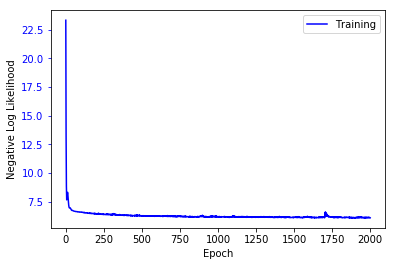

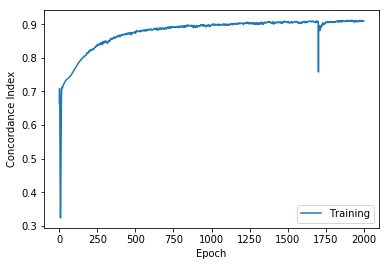

In [6]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)